In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
from datetime import date
from scipy import interpolate
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/plotMithraPy')
import plotMiFuncs as pmf

raw_data = []

###########################################################################################
###########################################################################################
# Instantiate basic stuff
fs = 14
footnote = 'A. Albà, ' + str(date.today())
for_report = True
denDir = 'densities/'
sliceDir = 'slice_energies/'
pltpath = 'plots'

###########################################################################################
###########################################################################################

print(footnote)
# Create folder for plots if it doesn't exist
if not os.path.exists(pltpath):
    os.mkdir(pltpath)
    print("Created folder " + pltpath)

def write_footnote(ax, x = .75, y = -.75):
    if for_report:
        ax.text( x, y, footnote, transform=ax.transAxes, fontsize = fs, ha='center' )


A. Albà, 2020-05-30


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
A. Albà, 2020-05-30


# Statistics

In [3]:
def plot_en(fn, ax):
    file = open(fn, "r")
    text = file.readlines()
    file.close()
    xEd = text[1].split(' ')
    x = np.linspace(float(xEd[0]), float(xEd[1]), int(xEd[2]))
    yEd = text[2].split(' ')
    y = np.linspace(float(yEd[0]), float(yEd[1]), int(yEd[2]))
    den = pd.read_csv(fn, skiprows = 3, header = None, index_col = False, names = ['den'])
    D = np.array(den['den'])
    D = np.reshape(D, [x.size-1,-1]).T
    D[D == 0.0] = None
    ax.imshow(D, origin = 'lower', extent = [x[0], x[-1], y[0], y[-1]], aspect = 'auto')

def plot_all(cases = [], fn = 'NaN', sort_by = 'NaN'):
    params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
    if len(cases) > 0:
        useFNs = ['case' + str(i) for i in cases]
        params = params[params['fname'].isin(useFNs)]
        if sort_by != 'NaN':
            params = params.sort_values(by = [sort_by])
        params = params.reset_index()
    num = len(params['fname'])
    fig, axs = plt.subplots(num, 1, figsize = (8, num * 4), sharex = True, sharey = True)
    for i in range(num):
        denFN = denDir + params['fname'][i] + '.den'
        plot_en(denFN, axs[i])
        NpC = (params['N'][i] / (params['MX'][i] * params['MY'][i] * params['MT'][i]))
        axs[i].text(1.2, .5, params['fname'][i] + ',\n N = '+ "{:.2e}".format(params['N'][i])
                    + ', NpC = '+"{:.3f}".format(NpC)
                    + ',\n MX = ' + str(params['MX'][i])
                    + ', MY = ' + str(params['MY'][i])
                    + ', MT = ' + str(params['MT'][i]) ,
                    fontsize = 12, transform=axs[i].transAxes, ha = 'center')
        axs[i].set_ylabel(r'$\beta_z\gamma$ [ ]', fontsize = 12)
    axs[-1].set_xlabel('t [ ]', fontsize = 12)
    if fn != 'NaN':
        print('Saving to ', pltpath + '/' + fn)
        plt.savefig( (pltpath + '/' + fn), bbox_inches='tight' )
        

In [4]:
# Reconstruct all
plot_all(cases = [0,4], fn = 'energies_highestRes.png')
plt.show()


Saving to  plots/energies_highestRes.png


test error function,  0.8164106460109258
nan row  99  in file  slice_energies/case5.slice
nan row  97  in file  slice_energies/case9.slice
nan row  98  in file  slice_energies/case9.slice


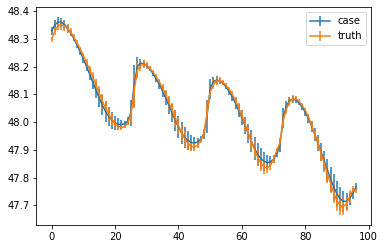

test slice-error function,  [0.009340560636730931, 0.005915422718092595, 0.006027411551391089, 0.004001831908035869]


In [5]:
def den_subtract(x, y, den, xT, yT, denT, plot = False):
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dxT = xT[1] - xT[0]
    dyT = yT[1] - yT[0]
    # Interpolate density functions
    den = np.reshape(den, [x.size,-1]).T
    den *= dx * dy / (dxT * dyT)
    den = interpolate.interp2d(x, y, den, kind = 'linear')
    denT = np.reshape(denT, [x.size,-1]).T
    denT = interpolate.interp2d(xT, yT, denT, kind = 'linear')
    
    # Extend domain
    if x[0] < xT[0]:
        n = np.ceil((xT[0] - x[0]) / dxT)
        add = np.linspace(xT[0]-n*dxT, xT[0]-dxT, int(n))
        xT = np.insert(xT,0,add)
    if x[-1] > xT[-1]:
        n = np.ceil((x[-1] - xT[-1]) / dxT)
        add = np.linspace(xT[-1]+dxT, xT[-1]+n*dxT, int(n))
        xT = np.append(xT,add)
    if y[0] < yT[0]:
        n = np.ceil((yT[0] - y[0]) / dyT)
        add = np.linspace(yT[0]-n*dyT, yT[0]-dyT, int(n))
        yT = np.insert(yT,0,add)
    if y[-1] > yT[-1]:
        n = np.ceil((y[-1] - yT[-1]) / dyT)
        add = np.linspace(yT[-1]+dyT, yT[-1]+n*dyT, int(n))
        yT = np.append(yT,add)

    if plot:
        fig,ax = plt.subplots(4, 1, figsize = (16,10))
        ax[0].imshow(den(xT,yT), origin = 'lower', extent = [xT[0], xT[-1], yT[0], yT[-1]], aspect = 'auto')
        ax[1].imshow(denT(xT,yT), origin = 'lower', extent = [xT[0], xT[-1], yT[0], yT[-1]], aspect = 'auto')
        ax[2].plot(xT, den(xT,yT[50]))
        ax[3].plot(xT, denT(xT,yT[50]))
        plt.show()
        
    return np.reshape((den(xT,yT) - denT(xT,yT)), -1)

def error(file1, fileT, plot = False):
    # Get data
    file = open(file1, "r")
    text = file.readlines()
    file.close()
    xEd = text[1].split(' ')
    yEd = text[2].split(' ')
    x = np.linspace(float(xEd[0]), float(xEd[1]), int(xEd[2]))[:-1]
    y = np.linspace(float(yEd[0]), float(yEd[1]), int(yEd[2]))[:-1]
    x += .5 * (x[1] - x[0])
    y += .5 * (y[1] - y[0])
    den = np.array(pd.read_csv(file1, skiprows = 3, header = None, index_col = False, names = ['den'])['den'])
    # Get truth
    file = open(fileT, "r")
    text = file.readlines()
    file.close()
    xEd = text[1].split(' ')
    yEd = text[2].split(' ')
    xT = np.linspace(float(xEd[0]), float(xEd[1]), int(xEd[2]))[:-1]
    yT = np.linspace(float(yEd[0]), float(yEd[1]), int(yEd[2]))[:-1]
    xT += .5 * (xT[1] - xT[0])
    yT += .5 * (yT[1] - yT[0])
    denT = np.array(pd.read_csv(fileT, skiprows = 3, header = None, index_col = False, names = ['den'])['den'])
                 
    return np.linalg.norm(den_subtract(x, y, den, xT, yT, denT, plot)) / np.linalg.norm(denT)


print('test error function, ', error('densities/case6.den', 'densities/case4.den', plot = False))

print('test slice-error function, ', pmf.sliceError('slice_energies/case5.slice', 'slice_energies/case9.slice', plot = True))


In [21]:
# Convergence MT
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'densities/#.den'
truthFN  = baseName.replace('#', 'case5')
useFNs = np.array([6,0,1,2,3,4])
# plot_all(cases = np.append(useFNs,5), fn = 'energies_convMT.png', sort_by = 'MT')
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = []
MT = []
err = []

for ind, row in params.iterrows():
    N.append(row['N'])
    MT.append(row['MT'])
    err.append(error(baseName.replace('#', row['fname']), truthFN))
N = np.array(N)
MT = np.array(MT)
err = np.array(err)

# Make linear fit
indFit = np.where(MT < 200)
[a,b] = np.polyfit(np.log10(MT[indFit]), np.log10(err[indFit]), 1)
def f(x):
    return x**a * 10**b

# Plot
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(MT, err, linestyle = 'None', marker = 'o')
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlabel('MT', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel('error (L2-norm)', fontsize = fs)
for i, el in enumerate(MT):
    ax.text( el, 1.05*err[i], 'N = ' + "{:.2e}".format(N[i]), ha='center' )
# Plot fit
ax.autoscale(False)
xlim = ax.get_xlim()
ax.plot(xlim, f(xlim), color = 'r', lw = 2)

ax.legend(["data", "err~MT$^{" + "{:.3f}".format(a) + "}$"], fontsize = fs )

params = params.iloc[0]
fig.suptitle('Convergence MT, Npc = 8\n MX = ' + str(params['MX']) + ', MY = ' + str(params['MY']), fontsize = fs)

plt.savefig( (pltpath + '/convergenceMT.png'), bbox_inches='tight' )
plt.show()


In [10]:
# Convergence MT slice-energy-spread
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'slice_energies/#.slice'
truthFN  = baseName.replace('#', 'case5')
useFNs = np.array([6,0,1,2,3,4])
# plot_all(cases = np.append(useFNs,5), fn = 'energies_convMT.png', sort_by = 'MT')
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = np.zeros(0)
MT = np.zeros(0)
errE = np.zeros(0)
errStd = np.zeros(0)
errEbar = np.zeros(0)
errStdbar = np.zeros(0)

for ind, row in params.iterrows():
    N = np.append(N, row['N'])
    MT = np.append(MT, row['MT'])
    errE = np.append(errE, pmf.sliceError(baseName.replace('#', row['fname']),
                                      truthFN)[0])
    errStd = np.append(errStd, pmf.sliceError(baseName.replace('#', row['fname']),
                                          truthFN)[1])
    errEbar = np.append(errEbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                            truthFN)[2])
    errStdbar = np.append(errStdbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                                truthFN)[3])

# Plot
fig, ax = plt.subplots(figsize = (10,5))
pmf.log_errorbary(ax, MT, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
pmf.log_errorbary(ax, MT, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
# ax.errorbar(MT, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
# ax.errorbar(MT, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ax.set_xticks(MT)
ax.set_xticklabels([str(int(mt)) for mt in MT])
ax.set_xlabel('MT', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel('error [MeV]', fontsize = fs)

ax.legend([r'$\langle|E_i - \hat E_i|\rangle$', r'$\langle|\sigma_{E,i} - \hat\sigma_{E,i}|\rangle$' ], fontsize = fs)

params = params.iloc[0]
fig.suptitle('Convergence MT,\n Npc = 8, MX = MY = ' + str(params['MX']) , fontsize = fs)

plt.savefig( (pltpath + '/slice_convergenceMT.png'), bbox_inches='tight' )
plt.show()

nan row  98  in file  slice_energies/case6.slice
nan row  99  in file  slice_energies/case6.slice
nan row  98  in file  slice_energies/case6.slice
nan row  99  in file  slice_energies/case6.slice
nan row  98  in file  slice_energies/case6.slice
nan row  99  in file  slice_energies/case6.slice
nan row  98  in file  slice_energies/case6.slice
nan row  99  in file  slice_energies/case6.slice
nan row  98  in file  slice_energies/case0.slice
nan row  99  in file  slice_energies/case0.slice
nan row  98  in file  slice_energies/case0.slice
nan row  99  in file  slice_energies/case0.slice
nan row  98  in file  slice_energies/case0.slice
nan row  99  in file  slice_energies/case0.slice
nan row  98  in file  slice_energies/case0.slice
nan row  99  in file  slice_energies/case0.slice
nan row  98  in file  slice_energies/case1.slice
nan row  99  in file  slice_energies/case1.slice
nan row  98  in file  slice_energies/case1.slice
nan row  99  in file  slice_energies/case1.slice


nan row  98  in file  slice_energies/case1.slice
nan row  99  in file  slice_energies/case1.slice
nan row  98  in file  slice_energies/case1.slice
nan row  99  in file  slice_energies/case1.slice
nan row  98  in file  slice_energies/case2.slice
nan row  99  in file  slice_energies/case2.slice
nan row  98  in file  slice_energies/case2.slice
nan row  99  in file  slice_energies/case2.slice
nan row  98  in file  slice_energies/case2.slice
nan row  99  in file  slice_energies/case2.slice
nan row  98  in file  slice_energies/case2.slice
nan row  99  in file  slice_energies/case2.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  98  in file  slice_energies/case4.slice
nan row  99  in file  slice_energies/case4.slice


nan row  98  in file  slice_energies/case4.slice
nan row  99  in file  slice_energies/case4.slice
nan row  98  in file  slice_energies/case4.slice
nan row  99  in file  slice_energies/case4.slice
nan row  98  in file  slice_energies/case4.slice
nan row  99  in file  slice_energies/case4.slice


Saving to  plots/energies_convMX.png


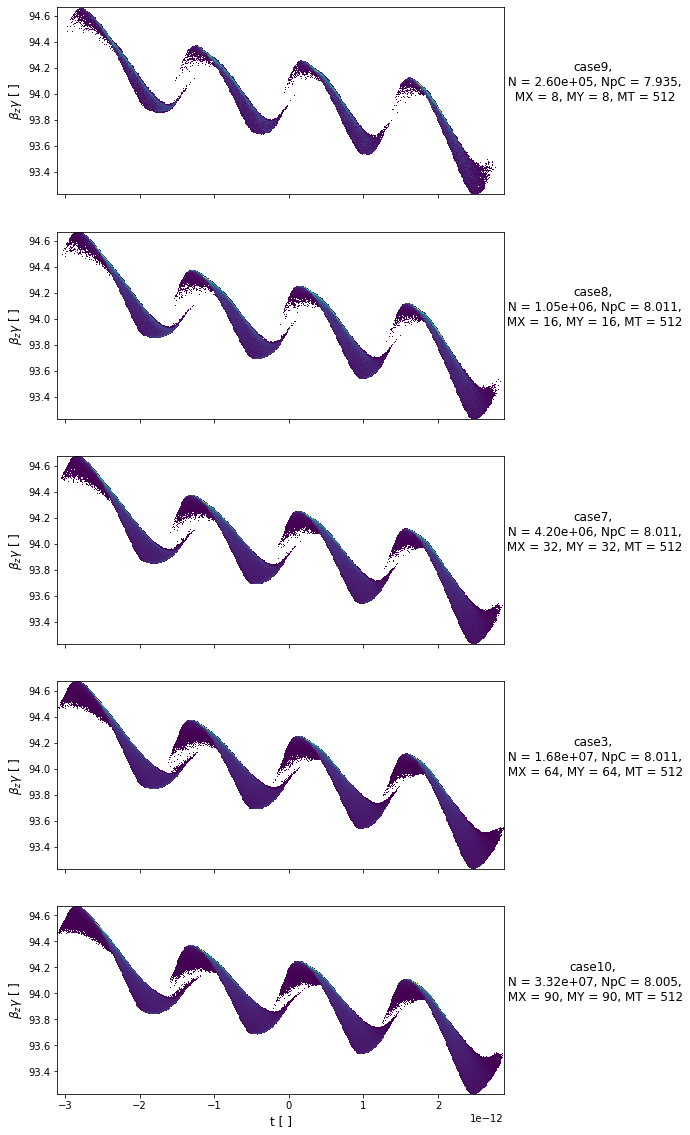

In [14]:
# Convergence MX
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'densities/#.den'
truthFN  = baseName.replace('#', 'case10')
useFNs = np.array([3,7,8,9])
plot_all(cases = np.append(useFNs,10), fn = 'energies_convMX.png', sort_by = 'MX')
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = []
MX = []
err = []

for ind, row in params.iterrows():
    N.append(row['N'])
    MX.append(row['MX'])
    err.append(error(baseName.replace('#', row['fname']), truthFN))
N = np.array(N)
MX = np.array(MX)
err = np.array(err)

# Make linear fit
indFit = np.where(MX < 45)
[a,b] = np.polyfit(np.log10(MX[indFit]), np.log10(err[indFit]), 1)
def f(x):
    return x**a * 10**b

# Plot
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(MX, err, linestyle = 'None', marker = 'o')
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlabel('MX', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel('error (L2-norm)', fontsize = fs)
for i, el in enumerate(MX):
    ax.text( el, 1.05*err[i], 'N = ' + "{:.2e}".format(N[i]), ha='center' )
# Plot fit
ax.autoscale(False)
xlim = ax.get_xlim()
ax.plot(xlim, f(xlim), color = 'r', lw = 2)

ax.legend(["data", "err~MX$^{" + "{:.3f}".format(a) + "}$"], fontsize = fs )

params = params.iloc[0]
fig.suptitle('Convergence MX, Npc = 8\n MT = ' + str(params['MT']), fontsize = fs)

plt.savefig( (pltpath + '/convergenceMX.png'), bbox_inches='tight' )
plt.show()

nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  98  in file  slice_energies/case7.slice
nan row  99  in file  slice_energies/case7.slice
nan row  98  in file  slice_energies/case7.slice
nan row  99  in file  slice_energies/case7.slice
nan row  98  in file  slice_energies/case7.slice
nan row  99  in file  slice_energies/case7.slice
nan row  98  in file  slice_energies/case7.slice
nan row  99  in file  slice_energies/case7.slice
nan row  98  in file  slice_energies/case8.slice
nan row  99  in file  slice_energies/case8.slice
nan row  98  in file  slice_energies/case8.slice
nan row  99  in file  slice_energies/case8.slice


nan row  98  in file  slice_energies/case8.slice
nan row  99  in file  slice_energies/case8.slice
nan row  98  in file  slice_energies/case8.slice
nan row  99  in file  slice_energies/case8.slice
nan row  97  in file  slice_energies/case9.slice
nan row  98  in file  slice_energies/case9.slice
nan row  99  in file  slice_energies/case9.slice
nan row  97  in file  slice_energies/case9.slice
nan row  98  in file  slice_energies/case9.slice
nan row  99  in file  slice_energies/case9.slice
nan row  97  in file  slice_energies/case9.slice
nan row  98  in file  slice_energies/case9.slice
nan row  99  in file  slice_energies/case9.slice
nan row  97  in file  slice_energies/case9.slice
nan row  98  in file  slice_energies/case9.slice
nan row  99  in file  slice_energies/case9.slice


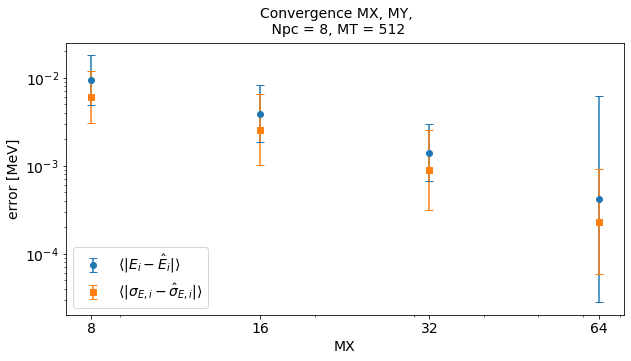

In [12]:
# Convergence MX slice-energy spread
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'slice_energies/#.slice'
truthFN  = baseName.replace('#', 'case10')
useFNs = np.array([3,7,8,9])
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = np.zeros(0)
MX = np.zeros(0)
errE = np.zeros(0)
errStd = np.zeros(0)
errEbar = np.zeros(0)
errStdbar = np.zeros(0)

for ind, row in params.iterrows():
    N = np.append(N, row['N'])
    MX = np.append(MX, row['MX'])
    errE = np.append(errE, pmf.sliceError(baseName.replace('#', row['fname']),
                                      truthFN)[0])
    errStd = np.append(errStd, pmf.sliceError(baseName.replace('#', row['fname']),
                                          truthFN)[1])
    errEbar = np.append(errEbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                            truthFN)[2])
    errStdbar = np.append(errStdbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                                truthFN)[3])

# Plot
fig, ax = plt.subplots(figsize = (10,5))
pmf.log_errorbary(ax, MX, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
pmf.log_errorbary(ax, MX, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
# ax.errorbar(MX, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
# ax.errorbar(MX, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ax.set_xticks(MX)
ax.set_xticklabels([str(int(mx)) for mx in MX])
plt.setp(ax.get_xminorticklabels(), visible=False)
plt.setp(ax.get_yminorticklabels(), visible=True)
ax.set_xlabel('MX', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel('error [MeV]', fontsize = fs)

ax.legend([r'$\langle|E_i - \hat E_i|\rangle$', r'$\langle|\sigma_{E,i} - \hat\sigma_{E,i}|\rangle$' ], fontsize = fs)

params = params.iloc[0]
fig.suptitle('Convergence MX, MY,\n Npc = 8, MT = ' + str(params['MT']), fontsize = fs)

plt.savefig( (pltpath + '/slice_convergenceMX.png'), bbox_inches='tight' )
plt.show()

Saving to  plots/energies_convN.png


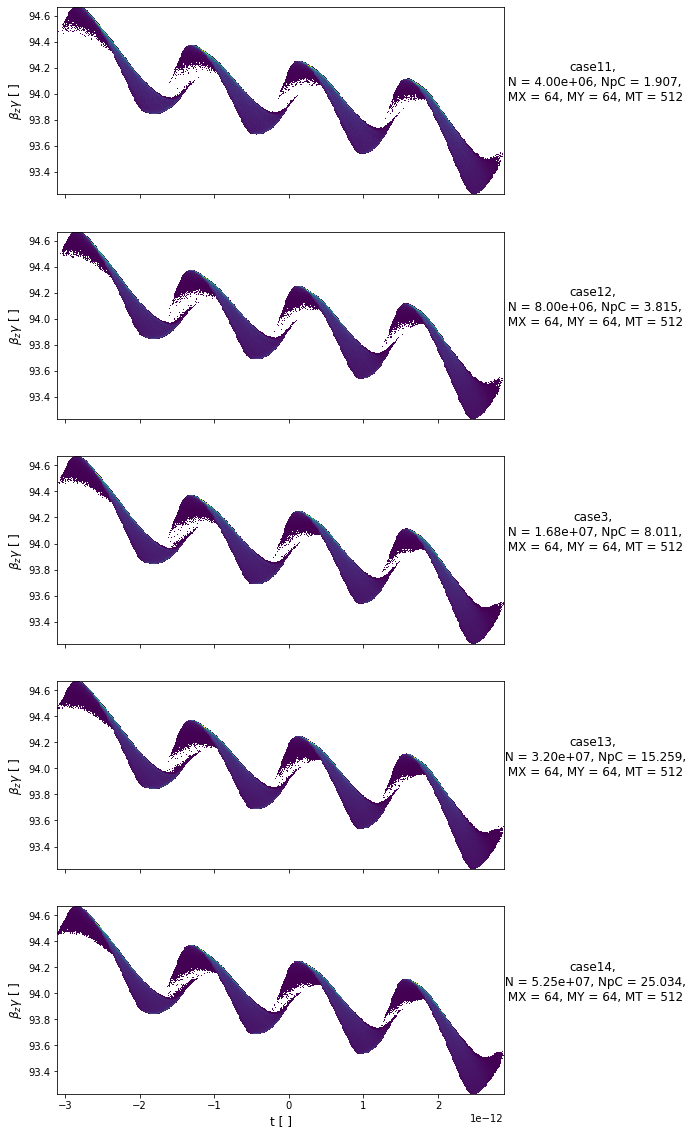

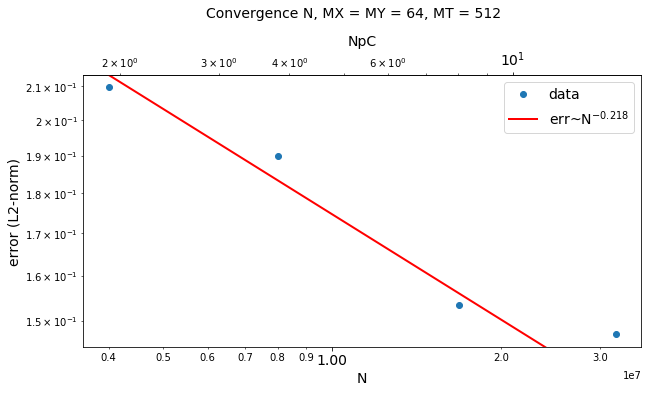

In [32]:
# Convergence N
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'densities/#.den'
truthFN  = baseName.replace('#', 'case14')
useFNs = np.array([11,12,3,13])
plot_all(cases = np.append(useFNs,14), fn = 'energies_convN.png', sort_by = 'N')
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = []
err = []

for ind, row in params.iterrows():
    N.append(row['N'])
    err.append(error(baseName.replace('#', row['fname']), truthFN))
N = np.array(N)
err = np.array(err)

# Make linear fit
indFit = np.where(N < 2e7)
[a,b] = np.polyfit(np.log10(N[indFit]), np.log10(err[indFit]), 1)
def f(x):
    return x**a * 10**b

# Plot
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(N, err, linestyle = 'None', marker = 'o')
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.set_xlabel('N', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel('error (L2-norm)', fontsize = fs)
# Plot fit
ax.autoscale(False)
xlim = ax.get_xlim()
ax.plot(xlim, f(xlim), color = 'r', lw = 2)

# Secondary axis
params = params.iloc[0]
def forward (N):
    return N / (params['MX'] * params['MY'] * params['MT'])
def backward (NpC):
    return NpC * (params['MX'] * params['MY'] * params['MT'])
secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.tick_params( axis = 'x', labelsize = fs )
secax.xaxis.set_major_formatter(mticker.ScalarFormatter())
secax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
secax.set_xlabel('NpC', fontsize = fs)

ax.legend(["data", "err~N$^{" + "{:.3f}".format(a) + "}$"], fontsize = fs )

fig.suptitle('Convergence N, MX = MY = ' + str(params['MX']) + ', MT = ' + str(params['MT']), fontsize = fs, y = 1.07)

plt.savefig( (pltpath + '/convergenceN.png'), bbox_inches='tight' )
plt.show()

Saving to  plots/test.png


nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  99  in file  slice_energies/case3.slice
nan row  98  in file  slice_energies/case17.slice
nan row  99  in file  slice_energies/case17.slice
nan row  98  in file  slice_energies/case17.slice
nan row  99  in file  slice_energies/case17.slice
nan row  98  in file  slice_energies/case17.slice
nan row  99  in file  slice_energies/case17.slice


nan row  98  in file  slice_energies/case17.slice
nan row  99  in file  slice_energies/case17.slice
nan row  98  in file  slice_energies/case11.slice
nan row  99  in file  slice_energies/case11.slice
nan row  98  in file  slice_energies/case11.slice
nan row  99  in file  slice_energies/case11.slice
nan row  98  in file  slice_energies/case11.slice
nan row  99  in file  slice_energies/case11.slice
nan row  98  in file  slice_energies/case11.slice
nan row  99  in file  slice_energies/case11.slice


nan row  98  in file  slice_energies/case12.slice
nan row  99  in file  slice_energies/case12.slice
nan row  98  in file  slice_energies/case12.slice
nan row  99  in file  slice_energies/case12.slice
nan row  98  in file  slice_energies/case12.slice
nan row  99  in file  slice_energies/case12.slice
nan row  98  in file  slice_energies/case12.slice
nan row  99  in file  slice_energies/case12.slice
nan row  99  in file  slice_energies/case13.slice
nan row  99  in file  slice_energies/case13.slice
nan row  99  in file  slice_energies/case13.slice


nan row  99  in file  slice_energies/case13.slice
nan row  99  in file  slice_energies/case14.slice
nan row  99  in file  slice_energies/case14.slice
nan row  99  in file  slice_energies/case14.slice
nan row  99  in file  slice_energies/case14.slice


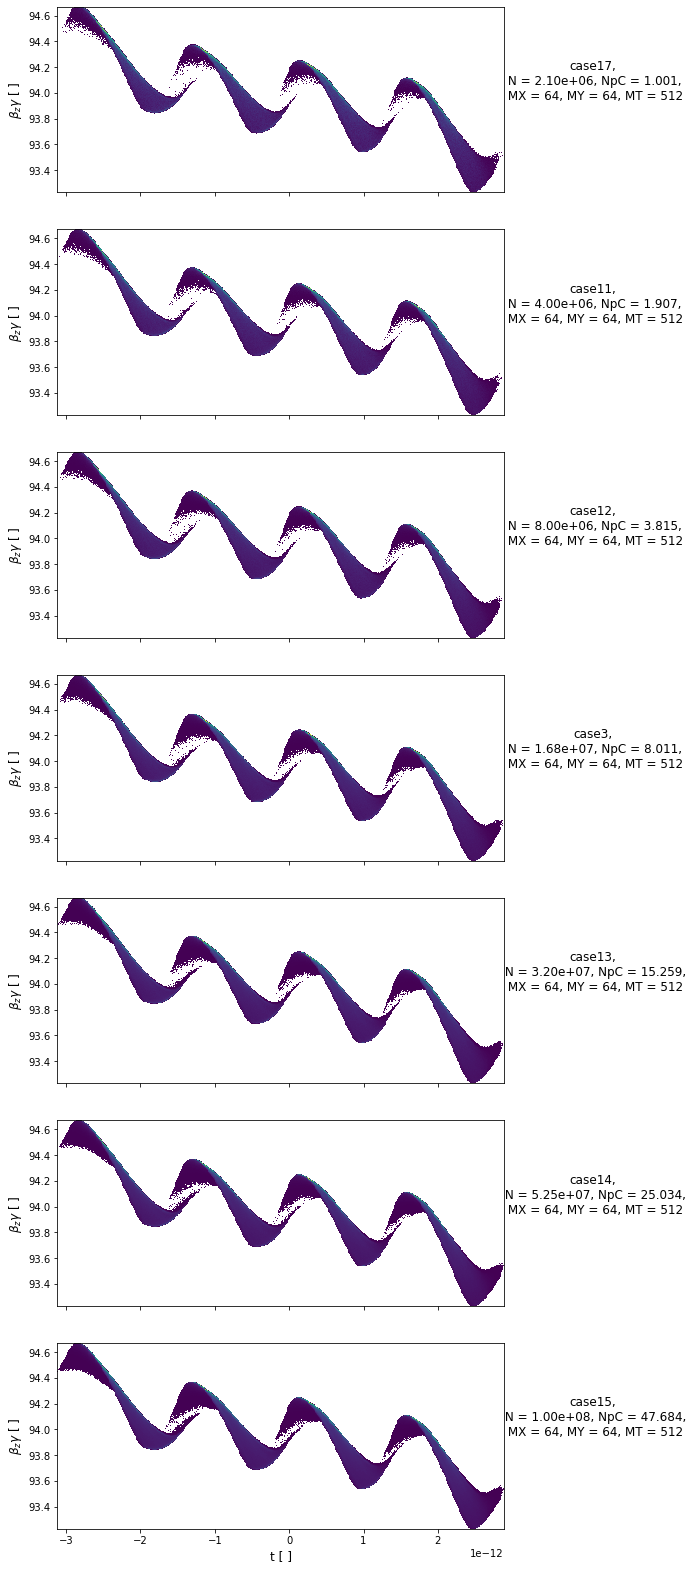

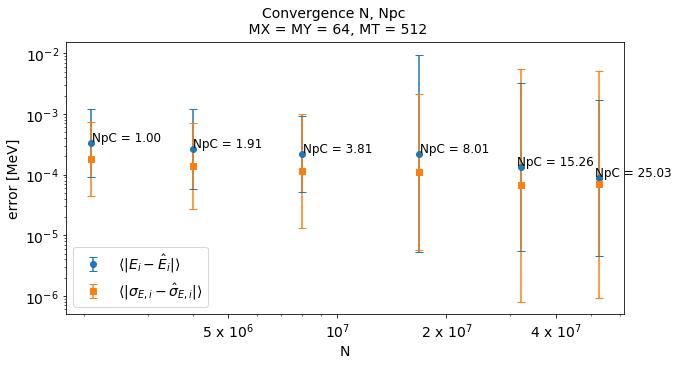

In [6]:
# Convergence N slice-energy spread
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
baseName = 'slice_energies/#.slice'
truthFN  = baseName.replace('#', 'case15')
useFNs = np.array([17,11,12,3,13,14])
plot_all(cases = np.append(useFNs,15), fn = 'test.png', sort_by = 'N')
useFNs = ['case' + str(i) for i in useFNs]
params = params[params['fname'].isin(useFNs)]
params = params.reset_index()
N = np.zeros(0)
NpC = np.zeros(0)
errE = np.zeros(0)
errStd = np.zeros(0)
errEbar = np.zeros(0)
errStdbar = np.zeros(0)

for ind, row in params.iterrows():
    N = np.append(N, row['N'])
    NpC = np.append(NpC, row['N'] / (row['MX'] * row['MY'] * row['MT']))
    errE = np.append(errE, pmf.sliceError(baseName.replace('#', row['fname']),
                                      truthFN)[0])
    errStd = np.append(errStd, pmf.sliceError(baseName.replace('#', row['fname']),
                                          truthFN)[1])
    errEbar = np.append(errEbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                            truthFN)[2])
    errStdbar = np.append(errStdbar, pmf.sliceError(baseName.replace('#', row['fname']),
                                                    truthFN)[3])
# Plot
fig, ax = plt.subplots(figsize = (10,5))
pmf.log_errorbary(ax, N, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
pmf.log_errorbary(ax, N, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
# ax.errorbar(N, errE, yerr = errEbar, linestyle = 'None', marker = 'o', capsize = 4)
# ax.errorbar(N, errStd, yerr = errStdbar, linestyle = 'None', marker = 's', capsize = 4)
ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xscale('log')
ticks = [5e6, 1e7, 2e7, 4e7]
ax.set_xticks(ticks)
ax.set_xticklabels(['$5$ x $10^6$', '$10^7$', '$2$ x $10^7$', '$4$ x $10^7$'])
ax.set_xlabel('N', fontsize = fs)
ax.set_yscale('log')
ax.set_ylabel(r'error [MeV]', fontsize = fs)
for i, el in enumerate(N):
    ax.text( 1.25*el, 1.07*errE[i], 'NpC = ' + "{:.2f}".format(NpC[i]), ha='center' , fontsize = 12)
ax.legend([r'$\langle|E_i - \hat E_i|\rangle$', r'$\langle|\sigma_{E,i} - \hat\sigma_{E,i}|\rangle$' ], fontsize = fs)

params = params.iloc[0]
fig.suptitle('Convergence N, Npc \n MX = MY = ' + str(params['MX']) + ', MT = ' + str(params['MT']), fontsize = fs)

# plt.savefig( (pltpath + '/slice_convergenceN.png'), bbox_inches='tight' )
plt.show()


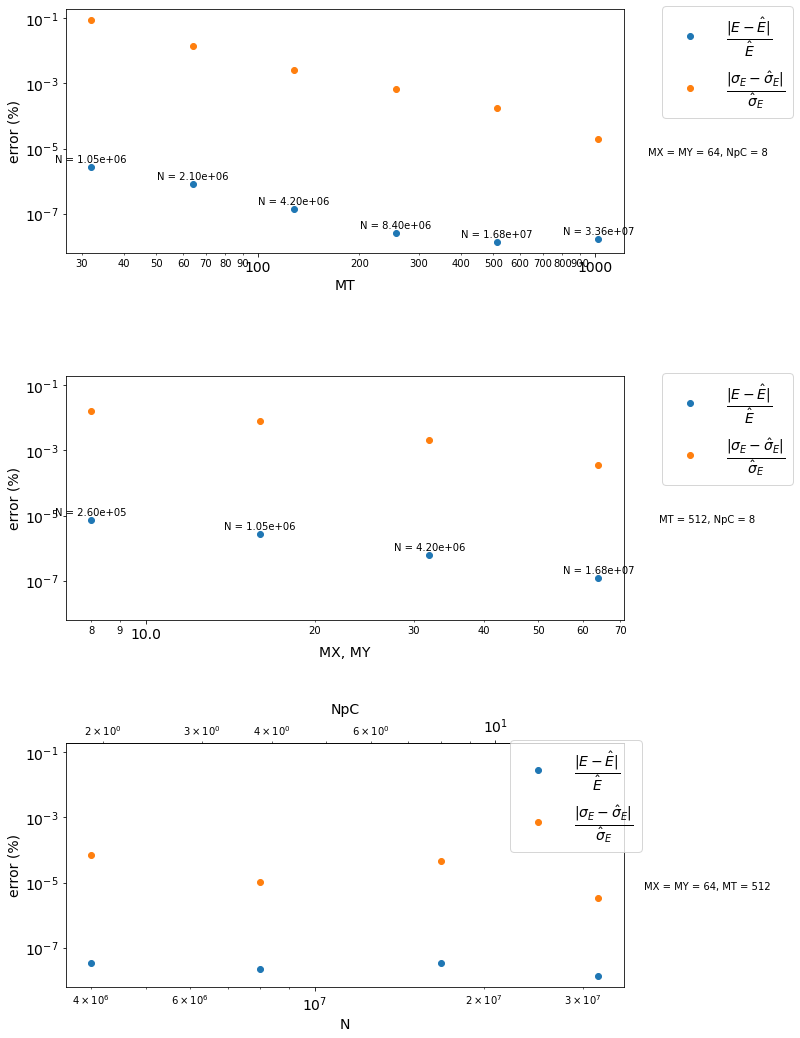

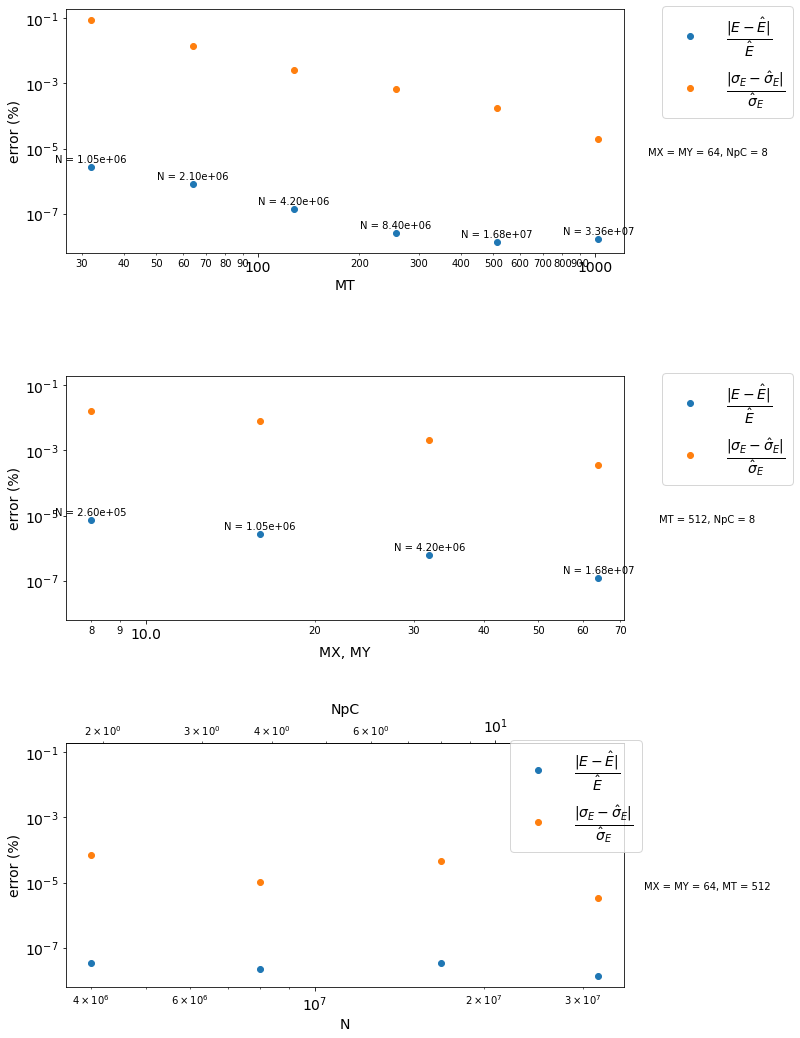

In [5]:
# Plot E and dE convergence
def plot_conv(xquant, xlab, quants, params, cases, caseTrue, ax, multx = 1, sec = False, lab = False):
    useFNs = ['case' + str(i) for i in cases]
    params = params[params['fname'].isin(useFNs)]
    params = params.reset_index()
    N = params['N']
    truth = (quants[quants['fname'] == 'case' + str(caseTrue)]).reset_index()
    ET = truth['E'][0]
    dET = truth['dE'][0]
    quants = quants[quants['fname'].isin(useFNs)]
    quants = quants.reset_index()
    x = np.array(params[xquant]) * multx
    errE = np.abs(np.array(quants['E']) - ET) / ET
    errdE = np.abs(np.array(quants['dE']) - dET) / dET
    ax.plot(x, errE, linestyle = 'None', marker = 'o')
    ax.plot(x, errdE, linestyle = 'None', marker = 'o')
    ax.tick_params(axis = 'x', labelsize = fs)
    ax.set_xscale('log')
    ax.set_xlabel(xlab, fontsize = fs)
    ax.set_yscale('log')
    if lab:
        for i, el in enumerate(x):
            ax.text( el, 1.4*errE[i], 'N = ' + "{:.2e}".format(N[i]), ha='center' )
    if 'M' in xquant:
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    # Secondary axis
    if sec:
        if xquant == 'N':
            Ncells = params['MX'][0] * params['MY'][0] * params['MT'][0]
            def forward (N):
                return N / Ncells / multx
            def backward (NpC):
                return NpC * Ncells * multx
        elif xquant == 'MT':
            NpCMT =   params['N'][0] / (params['MX'][0] * params['MY'][0])
            def forward (MT):
                return NpCMT / (MT / multx)
            def backward (NpC):
                return NpCMT / NpC * multx
        elif xquant == 'MX':
            NpCMXY =   params['N'][0] / params['MT'][0]
            def forward (MX):
                return NpCMXY / (MX / multx)**2
            def backward (NpC):
                return np.sqrt(NpCMXY / NpC) * multx
        secax = ax.secondary_xaxis('top', functions=(forward, backward))
        secax.tick_params( axis = 'x', labelsize = fs )
        secax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        secax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        secax.set_xlabel('NpC', fontsize = fs)
    
params = pd.read_csv('cases.txt', skiprows = 1, comment  = '#', sep = ' ')
quants = pd.read_csv('quants.tsv', sep = ' ')
fig, axs = plt.subplots(3, 1,  figsize = (10,18), sharey = True)
# MT
plot_conv('MT', xlab = 'MT', quants = quants,
          params = params, cases = [6,0,1,2,3,4], caseTrue = 5, ax = axs[0], lab = True)
axs[0].text(1.15,.4, 'MX = MY = 64, NpC = 8', transform=axs[0].transAxes, fontsize = 10, ha='center')
axs[0].set_ylabel('error (%)', fontsize = fs)
axs[0].tick_params(axis = 'y', labelsize = fs)
axs[0].legend([r'$\frac{|E-\hat E|}{\hat E}$', r'$\frac{|\sigma_E-\hat \sigma_E|}{\hat \sigma_E}$'], fontsize = 20, bbox_to_anchor=(1.05, 1.05))

# MX
plot_conv('MX', xlab = 'MX, MY', quants = quants,
          params = params, cases = [3,7,8,9], caseTrue = 10, ax = axs[1], lab = True)
axs[1].text(1.15,.4, 'MT = 512, NpC = 8', transform=axs[1].transAxes, fontsize = 10, ha='center')
axs[1].set_ylabel('error (%)', fontsize = fs)
axs[1].tick_params(axis = 'y', labelsize = fs)
axs[1].legend([r'$\frac{|E-\hat E|}{\hat E}$', r'$\frac{|\sigma_E-\hat \sigma_E|}{\hat \sigma_E}$'], fontsize = 20, bbox_to_anchor=(1.05, 1.05))

# N
plot_conv('N', xlab = 'N', quants = quants,
          params = params, cases = [11,12,3,13], caseTrue = 14, ax = axs[2], sec = True)
axs[2].text(1.15,.4, 'MX = MY = 64, MT = 512', transform=axs[2].transAxes, fontsize = 10, ha='center')
axs[2].set_ylabel('error (%)', fontsize = fs)
axs[2].tick_params(axis = 'y', labelsize = fs)
axs[2].legend([r'$\frac{|E-\hat E|}{\hat E}$', r'$\frac{|\sigma_E-\hat \sigma_E|}{\hat \sigma_E}$'], fontsize = 20, bbox_to_anchor=(1.05, 1.05))

plt.subplots_adjust(wspace = .02, hspace = .5)
plt.savefig( (pltpath + '/convergenceE.png'), bbox_inches='tight' )

plt.show()

